## Import required library packages

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve,ConfusionMatrixDisplay, classification_report
from helper.aws_helper import S3Connection

## Import Dataset from AWS S3 bucket

In [109]:
# instantiate and read dataset
conn = S3Connection()
loan_df = conn.read_file("loan-pred-docs/loan-prediction-dataset.csv",
                                     "loan-pred-docs")

In [110]:
# see the first 5 data row
loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [111]:
# dimension of data set
loan_df.shape

(614, 13)

In [112]:
# data types of columns in data set
loan_df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

### Analyse and fill in missing data

In [113]:
# sum up missing data per column
loan_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### Fill in categorical missing features with the mode

In [114]:
# create separate memory for dataset with no missing data
loan_no_missing_data_df = loan_df

In [115]:
# Gender, Married, Dependents, Self_Employed, Loan_Amount_Term and Credit_History features are categorised, 
# therefore, we use the modes to fill in missing datas

# Gender
loan_no_missing_data_df['Gender'] = loan_no_missing_data_df['Gender'].fillna(loan_no_missing_data_df['Gender'].mode()[0])
# Married
loan_no_missing_data_df['Married'] = loan_no_missing_data_df['Married'].fillna(loan_no_missing_data_df['Married'].mode()[0])
# Dependents
loan_no_missing_data_df['Dependents'] = loan_no_missing_data_df['Dependents'].fillna(loan_no_missing_data_df['Dependents'].mode()[0])
# Self_Employed
loan_no_missing_data_df['Self_Employed'] = loan_no_missing_data_df['Self_Employed'].fillna(loan_no_missing_data_df['Self_Employed'].mode()[0])
# Loan_Amount_Term
loan_no_missing_data_df['Loan_Amount_Term'] = loan_no_missing_data_df['Loan_Amount_Term'].fillna(loan_no_missing_data_df['Loan_Amount_Term'].mode()[0])
# Credit_History
loan_no_missing_data_df['Credit_History'] = loan_no_missing_data_df['Credit_History'].fillna(loan_no_missing_data_df['Credit_History'].mode()[0])

#### Fill in continuous missing features with the mean

In [116]:
# LoanAmount feature is continuous,therefore, we use the mean to fill in missing datas
loan_no_missing_data_df['LoanAmount'] = loan_no_missing_data_df['LoanAmount'].fillna(loan_no_missing_data_df['LoanAmount'].mean())

In [117]:
# confirm there is no more missing data
loan_no_missing_data_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [118]:
loan_no_missing_data_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


## Check for outliers in continuous features

In [119]:
loan_no_missing_data_describe_df = loan_no_missing_data_df[["ApplicantIncome","CoapplicantIncome", "LoanAmount"]].describe()

In [120]:
loan_no_missing_data_describe_df

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,84.037468
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.250000
50%,3812.500000,1188.500000,129.000000
75%,5795.000000,2297.250000,164.750000
max,81000.000000,41667.000000,700.000000


In [121]:
# InterQuartile range check, to find lower and higher outliers per continuous features
def IQR_check(df):
    IQR_info = {}
    for col in df.columns:
        # dictionary of lower and higher outliers per numeric features, using Q1 - 1.5*IQR & Q3 - 1.5*IQR 
        IQR_info[col] = [df[col].loc["25%"] - 1.5*df[col].loc["25%"], df[col].loc["75%"] + 1.5*df[col].loc["75%"]]
    return IQR_info

In [122]:
# call the IQR function with data
IQR_check(loan_no_missing_data_describe_df)

{'ApplicantIncome': [np.float64(-1438.75), np.float64(14487.5)],
 'CoapplicantIncome': [np.float64(0.0), np.float64(5743.125)],
 'LoanAmount': [np.float64(-50.125), np.float64(411.875)]}

In [123]:
IQR_range = IQR_check(loan_no_missing_data_describe_df)

In [124]:
# Create a column to indicate if `ApplicantIncome` column is an outlier using the lower and higher limit
loan_no_missing_data_df["ApplicantIncome_is_outlier"] = loan_no_missing_data_df["ApplicantIncome"].apply(lambda x: "Yes" if x < IQR_range["ApplicantIncome"][0] or x > IQR_range["ApplicantIncome"][1] else "No")

# Create a column to indicate if `CoapplicantIncome` column is an outlier using the lower and higher limit
loan_no_missing_data_df["CoapplicantIncome_is_outlier"] = loan_no_missing_data_df["CoapplicantIncome"].apply(lambda x: "Yes" if x < IQR_range["CoapplicantIncome"][0] or x > IQR_range["CoapplicantIncome"][1] else "No")

# Create a column to indicate if `LoanAmount` column is an outlier using the lower and higher limit
loan_no_missing_data_df["LoanAmount_is_outlier"] = loan_no_missing_data_df["LoanAmount"].apply(lambda x: "Yes" if x < IQR_range["LoanAmount"][0] or x > IQR_range["LoanAmount"][1] else "No")

# Create a column to indicate if all of `ApplicantIncome, CoapplicantIncome or LoanAmount` columns is an outlier
loan_no_missing_data_df['All_outliers'] = loan_no_missing_data_df[["ApplicantIncome_is_outlier", "CoapplicantIncome_is_outlier", "LoanAmount_is_outlier"]].apply(lambda x: "Yes" if x.isin(["Yes"]).sum() == 3 else "No", axis=1)

In [125]:
loan_no_missing_data_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_is_outlier,CoapplicantIncome_is_outlier,LoanAmount_is_outlier,All_outliers
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,No,No,No,No
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,No,No,No,No
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,No,No,No,No
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,No,No,No,No
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,No,No,No,No
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y,No,No,No,No
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y,No,No,No,No
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y,No,No,No,No


In [126]:
# find out were there are outliers
loan_no_missing_data_df.ApplicantIncome_is_outlier.value_counts(), loan_no_missing_data_df.CoapplicantIncome_is_outlier.value_counts(), loan_no_missing_data_df.LoanAmount_is_outlier.value_counts(), loan_no_missing_data_df.All_outliers.value_counts()

(ApplicantIncome_is_outlier
 No     582
 Yes     32
 Name: count, dtype: int64,
 CoapplicantIncome_is_outlier
 No     596
 Yes     18
 Name: count, dtype: int64,
 LoanAmount_is_outlier
 No     601
 Yes     13
 Name: count, dtype: int64,
 All_outliers
 No     613
 Yes      1
 Name: count, dtype: int64)

In [127]:
# focus on rows were all continuous columns are outliers
loan_no_missing_data_df[loan_no_missing_data_df["All_outliers"] == "Yes"]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_is_outlier,CoapplicantIncome_is_outlier,LoanAmount_is_outlier,All_outliers
506,LP002624,Male,Yes,0,Graduate,No,20833,6667.0,480.0,360.0,1.0,Urban,Y,Yes,Yes,Yes,Yes


In [128]:
# Drop the one line where the all continuous features are outlier
loan_no_missing_data_df = loan_no_missing_data_df.drop(loan_no_missing_data_df[loan_no_missing_data_df["All_outliers"] == "Yes"].index)

In [129]:
loan_no_missing_data_df.shape

(613, 17)

In [130]:
# remove the Loan ID, as it does not give additional information to our data, also remove the new outlier columns add as these are no longer needed
loan_no_missing_data_df.drop(columns=["Loan_ID", "All_outliers", "ApplicantIncome_is_outlier", "CoapplicantIncome_is_outlier", "LoanAmount_is_outlier"], inplace=True)

In [131]:
# combine the Applicant and co-applicant income as one to create a new `TotalIncome`
loan_no_missing_data_df['TotalIncome'] = loan_no_missing_data_df['ApplicantIncome'] + loan_no_missing_data_df['CoapplicantIncome']

In [132]:
loan_no_missing_data_df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,2900.0
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y,4106.0
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y,8312.0
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y,7583.0


## Graphical analysis of features that are continuous 

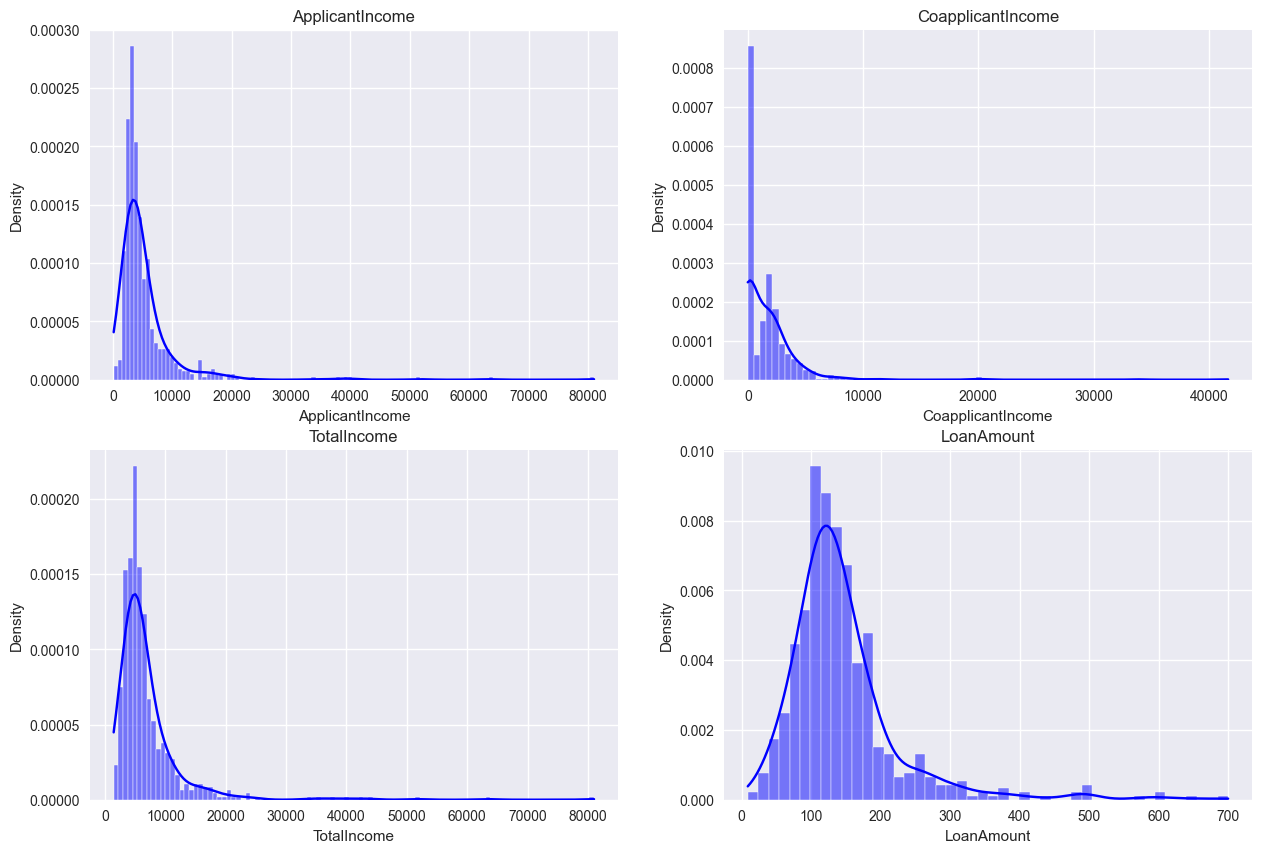

In [133]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].set_title("ApplicantIncome")
sns.histplot(loan_no_missing_data_df['ApplicantIncome'], color="blue", kde=True,
    stat="density",ax=axes[0,0]);

axes[0,1].set_title("CoapplicantIncome")
sns.histplot(loan_no_missing_data_df['CoapplicantIncome'], color="blue", kde=True,
    stat="density",ax=axes[0,1]);

axes[1,0].set_title("TotalIncome")
sns.histplot(loan_no_missing_data_df['TotalIncome'], color="blue", kde=True,
             stat="density",ax=axes[1,0])

axes[1,1].set_title('LoanAmount');
sns.histplot(loan_no_missing_data_df['LoanAmount'], color="blue", kde=True,
    stat="density",ax=axes[1,1]);
plt.style.use("seaborn-v0_8")

In [134]:
# Create table for just features that are continuous 
loan_no_missing_data_cf =  loan_no_missing_data_df[['ApplicantIncome','CoapplicantIncome', 'LoanAmount', 'TotalIncome']].copy()

In [135]:
corr = loan_no_missing_data_cf.corr()

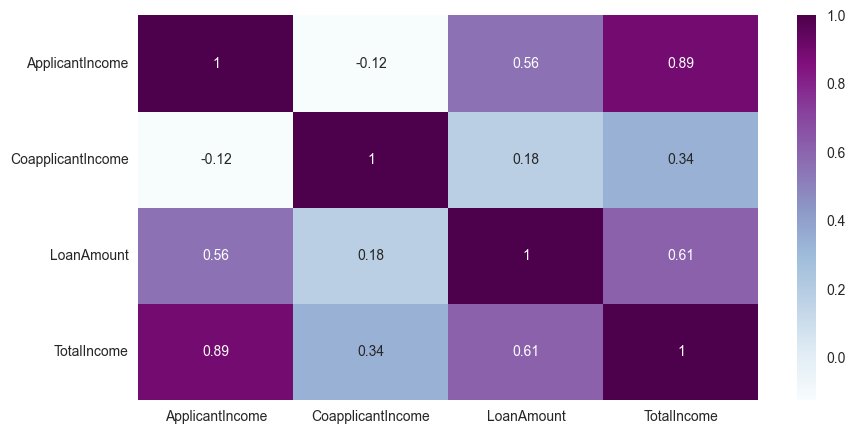

In [136]:
# see the correlation heatmap
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot = True, cmap = "BuPu");

In [137]:
# Drop "ApplicantIncome" and "CoapplicantIncome" columns now we have a column that sums them together 
loan_no_missing_data_df.drop(columns=['ApplicantIncome','CoapplicantIncome'], inplace=True)
loan_no_missing_data_df.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,Male,No,0,Graduate,No,146.412162,360.0,1.0,Urban,Y,5849.0
1,Male,Yes,1,Graduate,No,128.000000,360.0,1.0,Rural,N,6091.0
2,Male,Yes,0,Graduate,Yes,66.000000,360.0,1.0,Urban,Y,3000.0
3,Male,Yes,0,Not Graduate,No,120.000000,360.0,1.0,Urban,Y,4941.0
4,Male,No,0,Graduate,No,141.000000,360.0,1.0,Urban,Y,6000.0


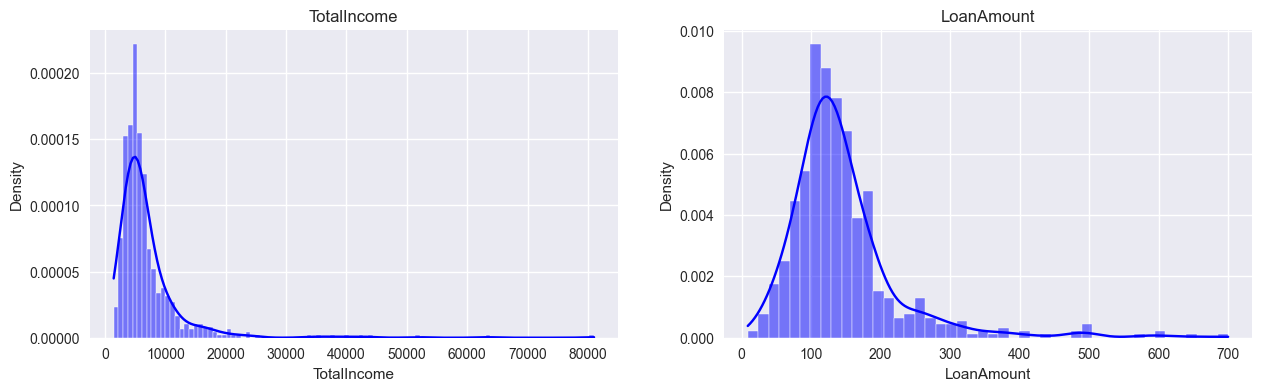

In [138]:
# histogram and density curve to show the distributions for both continuous coloumns(TotalIncome & LoanAmount)
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].set_title("TotalIncome")
sns.histplot(loan_no_missing_data_df['TotalIncome'], color="blue", kde=True,
    stat="density",ax=axes[0]);

axes[1].set_title("LoanAmount")
sns.histplot(loan_no_missing_data_df['LoanAmount'], color="blue", kde=True,
    stat="density",ax=axes[1]);

plt.style.use("seaborn-v0_8")

## Feature Scaling

In [139]:
# Apply normalisation to LoanAmount column
loan_no_missing_data_df["LoanAmount"] = loan_no_missing_data_df["LoanAmount"].apply(lambda x: (x + loan_no_missing_data_df["LoanAmount"].min())/(loan_no_missing_data_df["LoanAmount"].max() - loan_no_missing_data_df["LoanAmount"].min()))

In [140]:
# Apply normalisation to TotalIcome column
loan_no_missing_data_df["TotalIncome"] = loan_no_missing_data_df["TotalIncome"].apply(lambda x: (x + loan_no_missing_data_df["TotalIncome"].min())/(loan_no_missing_data_df["TotalIncome"].max() - loan_no_missing_data_df["TotalIncome"].min()))

In [141]:
# lets see what this two continuous column looks like after transformation
loan_no_missing_data_df[["LoanAmount","TotalIncome"]].head()

,LoanAmount,TotalIncome
0,0.224909,0.091644
1,0.198263,0.094686
2,0.108538,0.055833
3,0.186686,0.080231
4,0.217077,0.093542


## Data Transformation

In [142]:
loan_no_missing_data_df

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,Male,No,0,Graduate,No,0.224909,360.0,1.0,Urban,Y,0.091644
1,Male,Yes,1,Graduate,No,0.198263,360.0,1.0,Rural,N,0.094686
2,Male,Yes,0,Graduate,Yes,0.108538,360.0,1.0,Urban,Y,0.055833
3,Male,Yes,0,Not Graduate,No,0.186686,360.0,1.0,Urban,Y,0.080231
4,Male,No,0,Graduate,No,0.217077,360.0,1.0,Urban,Y,0.093542
...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,0.115774,360.0,1.0,Rural,Y,0.054577
610,Male,Yes,3+,Graduate,No,0.070912,180.0,1.0,Rural,Y,0.069735
611,Male,Yes,1,Graduate,No,0.379161,360.0,1.0,Urban,Y,0.122602
612,Male,Yes,2,Graduate,No,0.283647,360.0,1.0,Urban,Y,0.113439


In [143]:
# Adjust skewness for both continuous coloumns above using logrithm,redraw graph
loan_no_missing_data_df['TotalIncome'] = np.log(loan_no_missing_data_df['TotalIncome'])
loan_no_missing_data_df['LoanAmount'] = np.log(loan_no_missing_data_df['LoanAmount'])
# fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].set_title("TotalIncome")
sns.histplot(loan_no_missing_data_df['TotalIncome'], color="blue", kde=True,
    stat="density",ax=axes[0]);

axes[1].set_title("LoanAmount")
sns.histplot(loan_no_missing_data_df['LoanAmount'], color="blue", kde=True,
    stat="density",ax=axes[1]);

plt.style.use("seaborn-v0_8")

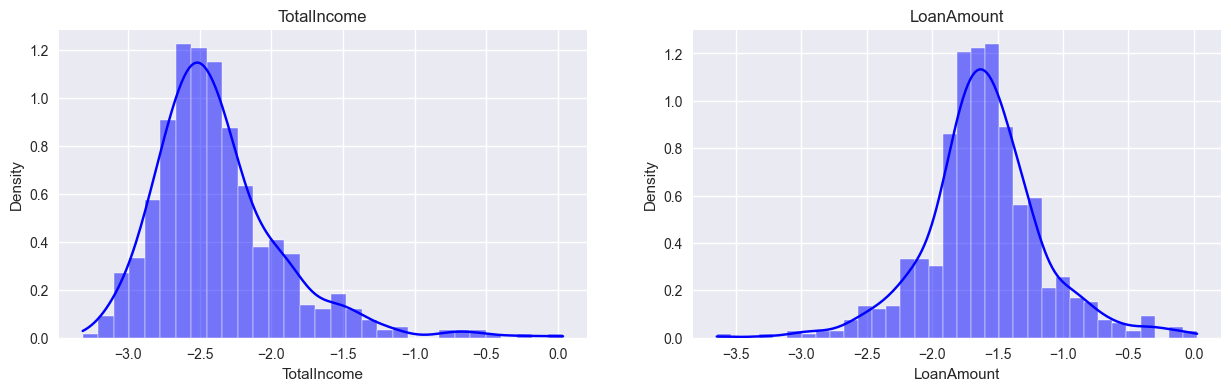

In [144]:
# plot 'TotalIncome' and 'LoanAmount'
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].set_title("TotalIncome")
sns.histplot(loan_no_missing_data_df['TotalIncome'], color="blue", kde=True,
    stat="density",ax=axes[0])

axes[1].set_title("LoanAmount")
sns.histplot(loan_no_missing_data_df['LoanAmount'], color="blue", kde=True,
    stat="density",ax=axes[1]);

In [146]:
# Get unique values in column "Dependents" & "Loan_Amount_Term"
loan_no_missing_data_df["Dependents"].unique(),loan_no_missing_data_df["Loan_Amount_Term"].unique()

(array(['0', '1', '2', '3+'], dtype=object),
 array([360., 120., 240., 180.,  60., 300., 480.,  36.,  84.,  12.]))

In [147]:
# Build my own label encoding
class LabelEncoding:
    def __init__(self):
        pass
    
    def fit(self, col):
        self.out = {}
        for idx, val in enumerate(col.unique()):
            self.out[val] = idx
            
    def transform(self, col):
        col = col.apply(lambda x: self.out[x])
        return col
    
    def fit_transform(self, col):
        self.fit(col)
        return self.transform(col)

In [148]:
# apply label encoding to categorised column ro make this numeric
cols = ["Gender", "Dependents", "Married", "Education", "Self_Employed", "Property_Area", "Loan_Status", "Loan_Amount_Term"]

le = LabelEncoder()

for col in cols:
    loan_no_missing_data_df[col] = le.fit_transform(loan_no_missing_data_df[col])

In [149]:
loan_no_missing_data_df.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,1,0,0,0,0,-1.492059,8,1.0,2,1,-2.389846
1,1,1,1,0,0,-1.618159,8,1.0,0,0,-2.357193
2,1,1,0,0,1,-2.220652,8,1.0,2,1,-2.885382
3,1,1,0,1,0,-1.678327,8,1.0,2,1,-2.522848
4,1,0,0,0,0,-1.527505,8,1.0,2,1,-2.369347


In [150]:
# Uploads a DataFrame as a CSV file to an S3 bucket.
conn.write_df(loan_no_missing_data_df, "loan-pred-docs", "loan-pred-docs/loan_no_missing_data_df.csv")

False

## Data Modelling

#### Model training

In [151]:
# Proceed to build and test our model'
# Split features and label dataset, where feature dataset is represented by `X` and label by `y`
X = loan_no_missing_data_df.drop(columns=['Loan_Status'], axis=1)
y = loan_no_missing_data_df["Loan_Status"]

In [152]:
# Split your train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1000,stratify=y)

In [153]:
y.value_counts(1)

Loan_Status
1    0.686786
0    0.313214
Name: proportion, dtype: float64

In [154]:
y_train.value_counts(1)

Loan_Status
1    0.687755
0    0.312245
Name: proportion, dtype: float64

In [155]:
# function to fit and score model
def classify(model, x_t, y_t):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000, stratify=y)
    
    model.fit(X_train, y_train)
    print("The accuracy: ", model.score(X_test, y_test) * 100)
    
    score = cross_val_score(model, x_t, y_t, cv=5)
    print("Cross Validate score: ", np.mean(score) * 100)

#### Using logistic regression algorithm

In [156]:
# Using logistic Regression
log_model = LogisticRegression()

In [157]:
# fit / train model
log_model.fit(X_train, y_train);

In [158]:
# Make a prediction with your test features
log_model.predict(X_test)

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [159]:
# actual test label
y_test.to_numpy()

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [160]:
# accuracy score for logistic Regression 
accuracy_score(y_test, log_model.predict(X_test))

0.8048780487804879

In [161]:
# precision score for logistic Regression 
precision_score(y_test, log_model.predict(X_test))

0.7884615384615384

In [162]:
# recall score for logistic Regression 
recall_score(y_test, log_model.predict(X_test))

0.9761904761904762

In [163]:
score = cross_val_score(log_model, X, y, cv=5)
print("Cross Validate score: ", np.mean(score) * 100)

Cross Validate score:  80.9236305477809


In [164]:
# confusion_matrix for logistic Regression 
confusion_matrix(y_test, log_model.predict(X_test))

array([[17, 22],
       [ 2, 82]])

In [165]:
# produce more colourful confusion matrix
def customise_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Purples):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap)
    plt.xlabel('Predicted labels')
    plt.ylabel('Actual labels')
    plt.title('Confusion Matrix')
    plt.show()

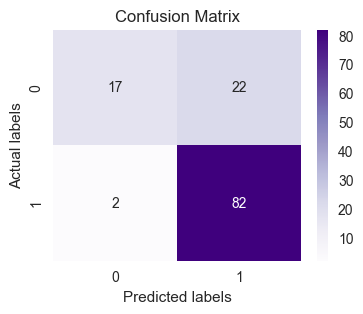

In [166]:
# confusion_matrix for logistic Regression 
customise_confusion_matrix(y_test, log_model.predict(X_test))

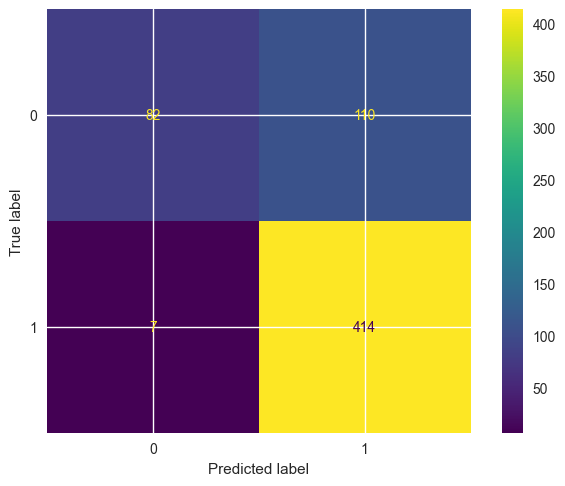

In [167]:
# OR
import sklearn

# Note this is from a fitted model and not predictions. Also, note we are passing all X and y date, 
# hence why we are getting more data
ConfusionMatrixDisplay.from_estimator(estimator=log_model,X=X, y=y);

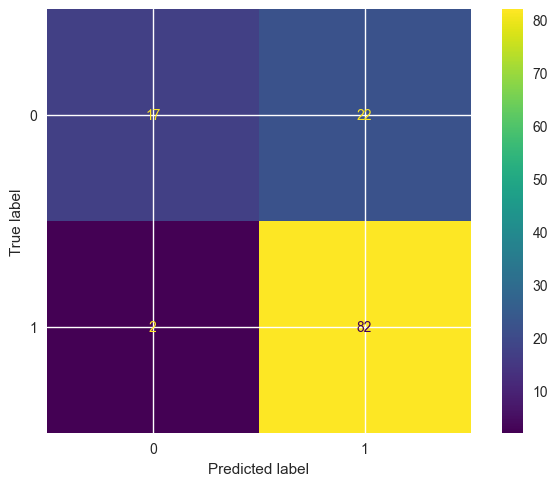

In [168]:
# Note this is from a predictions
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=log_model.predict(X_test));

In [169]:
# confusion_matrix for logistic Regression 
roc_auc_score(y_test, log_model.predict(X_test))

np.float64(0.706043956043956)

#### Using RandomForestClassifier algorithm

In [170]:
# RandomForestClassifier algorithm
# Try different amount of n_estimate to see which is better
np.random.seed(1000) # so our results are replicable
for i in range (10, 200, 10):
    print(f"Trying model with {i} estimators ...")
    rand_model = RandomForestClassifier(n_estimators=i).fit(X_train, y_train)
    print(f"Model accuracy on the test set: {accuracy_score(y_test, rand_model.predict(X_test)) * 100:.2f}%")
    print(f"Model precision on the test set: {precision_score(y_test, rand_model.predict(X_test)) * 100:.2f}%")
    print(f"Model recall on the test set: {recall_score(y_test, rand_model.predict(X_test)) * 100:.2f}%")

Trying model with 10 estimators ...
Model accuracy on the test set: 71.54%
Model precision on the test set: 77.53%
Model recall on the test set: 82.14%
Trying model with 20 estimators ...
Model accuracy on the test set: 71.54%
Model precision on the test set: 76.92%
Model recall on the test set: 83.33%
Trying model with 30 estimators ...
Model accuracy on the test set: 77.24%
Model precision on the test set: 79.17%
Model recall on the test set: 90.48%
Trying model with 40 estimators ...
Model accuracy on the test set: 79.67%
Model precision on the test set: 79.80%
Model recall on the test set: 94.05%
Trying model with 50 estimators ...
Model accuracy on the test set: 78.86%
Model precision on the test set: 79.59%
Model recall on the test set: 92.86%
Trying model with 60 estimators ...
Model accuracy on the test set: 79.67%
Model precision on the test set: 79.80%
Model recall on the test set: 94.05%
Trying model with 70 estimators ...
Model accuracy on the test set: 78.05%
Model precisi

**The results above indicate that the best estimator for the chosen range is `90`. For this model training `n_estimator = 90` will be used**

In [171]:
np.random.seed(1000) # so our results are replicable
rand_model = RandomForestClassifier(n_estimators=130).fit(X_train, y_train)
print(f"Model accuracy on the test set: {accuracy_score(y_test, rand_model.predict(X_test)) * 100:.2f}%")
print(f"Model precision on the test set: {precision_score(y_test, rand_model.predict(X_test)) * 100:.2f}%")
print(f"Model recall on the test set: {recall_score(y_test, rand_model.predict(X_test)) * 100:.2f}%")

Model accuracy on the test set: 79.67%
Model precision on the test set: 79.80%
Model recall on the test set: 94.05%


In [172]:
# confusion_matrix for RandomForestClassifier 
confusion_matrix(y_test, rand_model.predict(X_test))

array([[19, 20],
       [ 5, 79]])

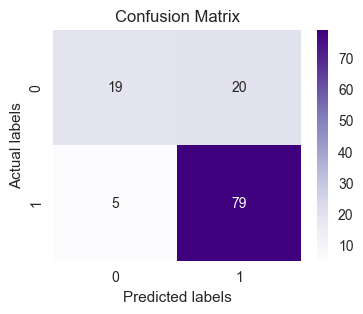

In [173]:
# confusion_matrix for RandomForestClassifier
customise_confusion_matrix(y_test, rand_model.predict(X_test))

In [174]:
score = cross_val_score(rand_model, X, y, cv=5)
print("Cross Validate score: ", np.mean(score) * 100)

Cross Validate score:  77.6609356257497


In [175]:
# confusion_matrix for RandomForestClassifier 
roc_auc_score(y_test, rand_model.predict(X_test))

np.float64(0.7138278388278388)

**Area under the receiver operating characteristics curve (AUC/POC) using results for RFC model**

* Area under curve (AUC)
* ROC curve

ROC curve: comparisons a model's true positive rate (`tpr`) versus a models false positive rate (`fpr`)

* True positive = model predicts 1 when truth is 1
* False positive = model predicts 1 when truth is 0
* True negative = model predicts 0 when truth is 0
* False negative = model predicts 0 when truth is 1

In [176]:
# Make predictions with probabilities
y_probs = rand_model.predict_proba(X_test)
y_probs[:10], len(y_probs)

(array([[0.32307692, 0.67692308],
        [0.03846154, 0.96153846],
        [0.27692308, 0.72307692],
        [0.32307692, 0.67692308],
        [0.3       , 0.7       ],
        [0.11538462, 0.88461538],
        [0.96153846, 0.03846154],
        [0.30769231, 0.69230769],
        [0.06923077, 0.93076923],
        [0.95384615, 0.04615385]]),
 123)

In [177]:
y_probs_positive = y_probs[:,1]
y_probs_positive[:10]

array([0.67692308, 0.96153846, 0.72307692, 0.67692308, 0.7       ,
       0.88461538, 0.03846154, 0.69230769, 0.93076923, 0.04615385])

In [178]:
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)

fpr

array([0.        , 0.        , 0.        , 0.02564103, 0.02564103,
       0.02564103, 0.07692308, 0.1025641 , 0.1025641 , 0.1025641 ,
       0.12820513, 0.15384615, 0.17948718, 0.17948718, 0.17948718,
       0.17948718, 0.17948718, 0.23076923, 0.25641026, 0.25641026,
       0.25641026, 0.28205128, 0.28205128, 0.28205128, 0.30769231,
       0.33333333, 0.33333333, 0.33333333, 0.38461538, 0.43589744,
       0.46153846, 0.46153846, 0.46153846, 0.48717949, 0.48717949,
       0.48717949, 0.48717949, 0.48717949, 0.51282051, 0.51282051,
       0.51282051, 0.51282051, 0.51282051, 0.51282051, 0.51282051,
       0.51282051, 0.56410256, 0.56410256, 0.61538462, 0.66666667,
       0.66666667, 0.69230769, 0.76923077, 0.76923077, 0.79487179,
       0.84615385, 0.92307692, 1.        ])

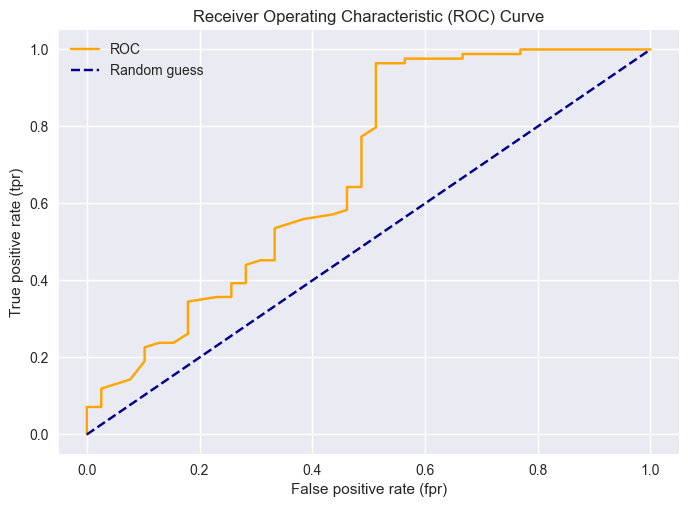

In [179]:
# Create a function for plotting ROC cureve

def roc_curve(fpr, tpr):
    
    plt.plot(fpr, tpr, color="orange", label="ROC")
    # Plot line with no predictive power (baselne)
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Random guess")
    
    # Customize the plot
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

roc_curve(fpr, tpr)

In [180]:
# Using the logistics regression print classification report
print(classification_report(y_test,log_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.44      0.59        39
           1       0.79      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.84      0.71      0.73       123
weighted avg       0.82      0.80      0.78       123



In [181]:
pd.DataFrame(classification_report(y_test,log_model.predict(X_test), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.894737,0.788462,0.804878,0.841599,0.822159
recall,0.435897,0.976190,0.804878,0.706044,0.804878
f1-score,0.586207,0.872340,0.804878,0.729274,0.781615
support,39.000000,84.000000,0.804878,123.000000,123.000000
